#### Validation of NEST and SpiNNaker running a Microcircuit simulation
---write sth---

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

Disable scrolling

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### Load functions for validation tools and visualization

In [81]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
load = imp.load_source('*', './load_spiketrains.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

data_path = '/home/robin/Projects/ValidationTools'
nest_path = data_path + "/sim_data/NEST_data"
spinnaker_path = data_path + "/sim_data/SpiNNaker_data"

##### Load spiketrains from simulation

In [41]:
layer = ['spikes_L23', 'spikes_L4', 'spikes_L5', 'spikes_L6']

spiketrains_nest = load.load(nest_path, layer)

spiketrains_spinnaker = load.load(spinnaker_path, layer)

##### Draw rasterplots for each layer

			NEST								SpiNNaker


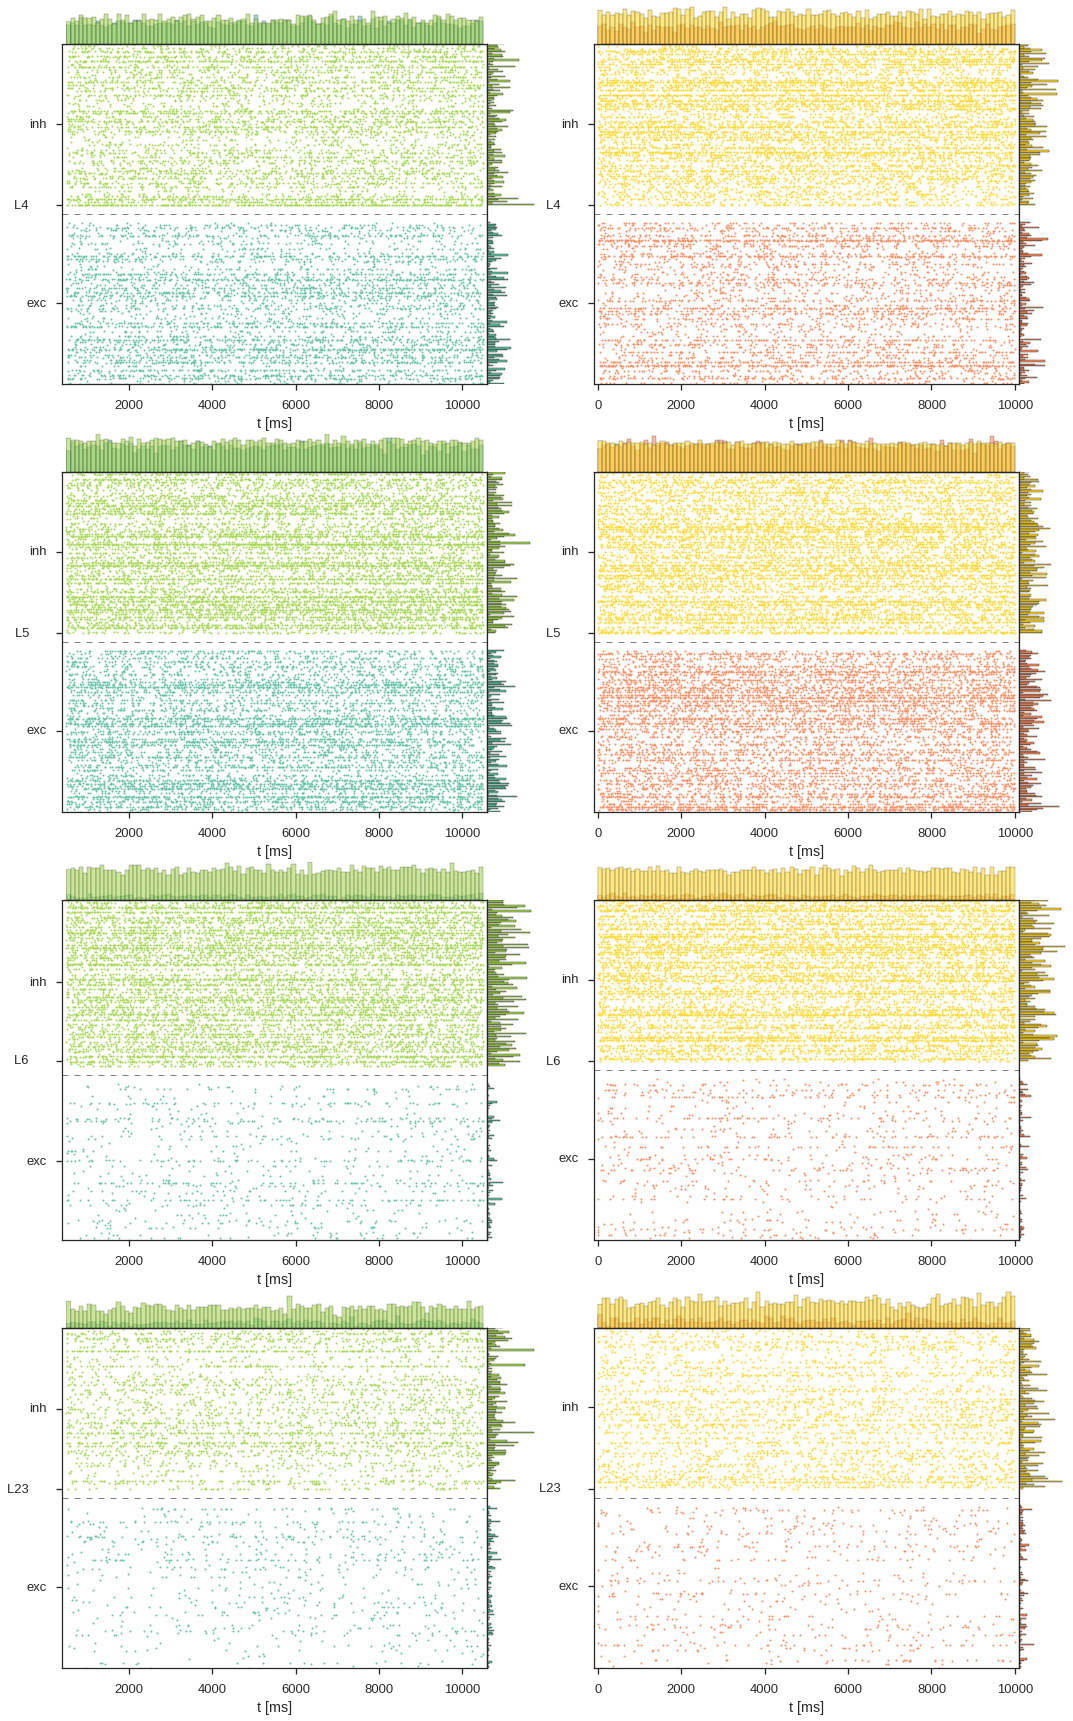

In [38]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,6*len(layer)))
fig.tight_layout()

argdict={'key_list':['layer', 'type', ''], 'colorkey':'type', 'groupingdepth':2,
         'spacing':10, 'labelkey':'0+1', 'context':'talk'}

for i in range(len(layer)):
    __ = vizi.rasterplot(spiketrains_nest[i], ax=ax[i][0], palette=sns.color_palette('Set2')[::4], **argdict)
    __ = vizi.rasterplot(spiketrains_spinnaker[i], ax=ax[i][1], palette=sns.color_palette('Set2')[1::4], **argdict)

print '\t'*3 + 'NEST' + '\t'*8 + 'SpiNNaker'

#### Compare the Distribution of Correlation-Coefficients

Calculate the correlation-coefficients and remove autocorrelatios

In [29]:
def corrcoef(spiketrains):
    ccs = []
    for layer_count, layer_sts in enumerate(spiketrains):
        ccs += [[]]
        for type_count, typ_sts in enumerate(layer_sts):
            ccs[layer_count] += [matstat.corr_matrix(typ_sts).flatten()]   
            # remove autocorrelations
            ccs[layer_count][type_count][ccs[layer_count][type_count] == 1] = 0
    return ccs
    
corrcoefs_nest = corrcoef(spiketrains_nest)
corrcoefs_spinnaker = corrcoef(spiketrains_spinnaker)

/usr/local/lib/python2.7/dist-packages/elephant/spike_train_correlation.py:247: RuntimeWarning: invalid value encountered in double_scalars
  C[i, j] = C[j, i] = enumerator / denominator


Show coefficient distribution for all layers and neuron types

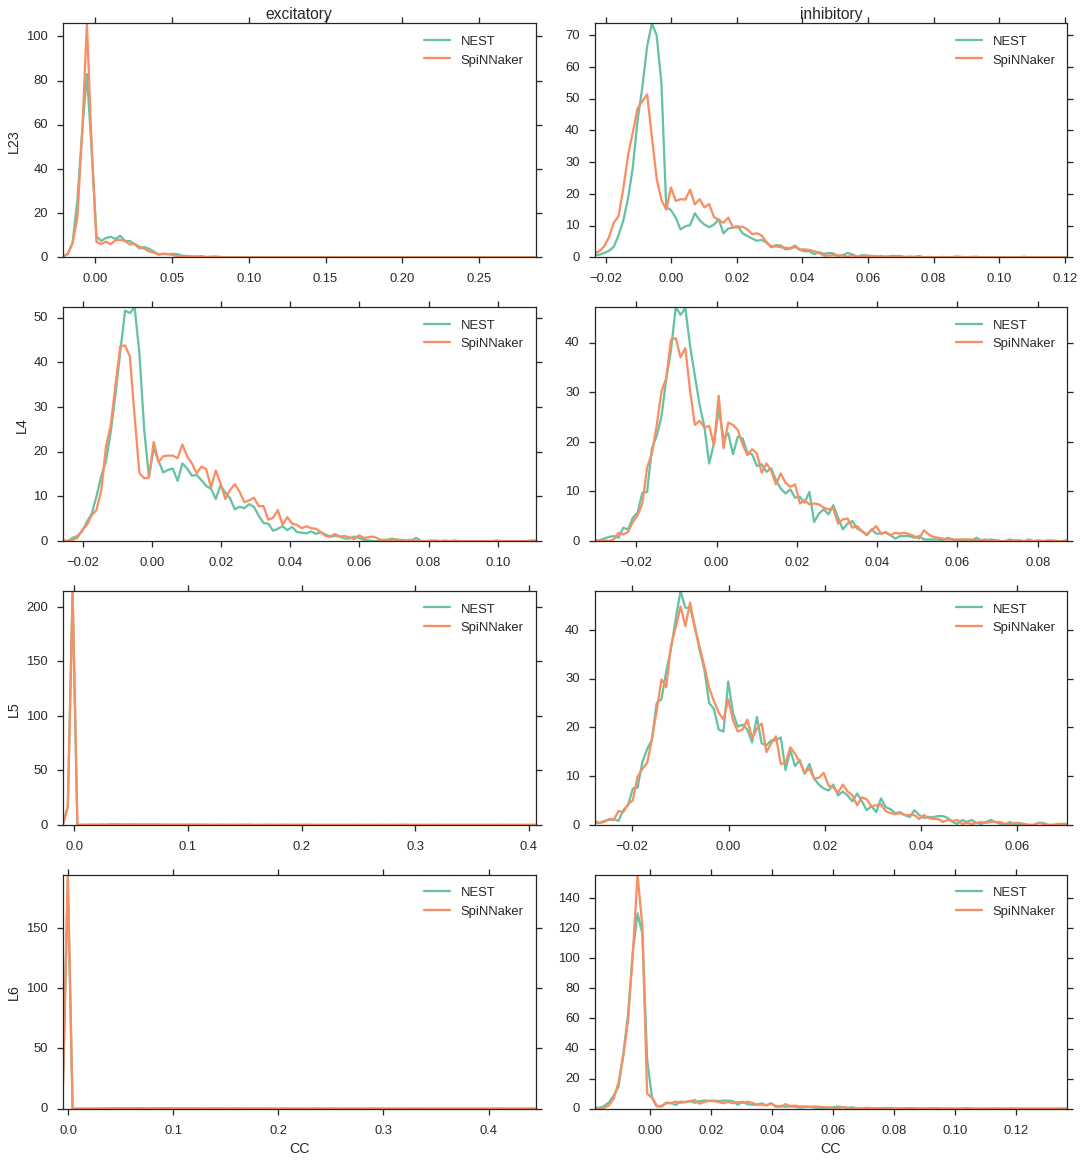

In [82]:
sns.set(style='ticks', palette='Set2', context='talk')
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    for typ_count in range(2):
        _ = dist.show(corrcoefs_nest[layer_count][typ_count], corrcoefs_spinnaker[layer_count][typ_count], 
                      bins=100, ax=ax[layer_count][typ_count])
        ax[layer_count][typ_count].legend(['NEST', 'SpiNNaker'])
    ax[layer_count][0].set_ylabel(layer_name.split('_')[1])
    
ax[0][0].set_title('excitatory')
ax[0][1].set_title('inhibitory')
ax[0][0].legend(['NEST', 'SpiNNaker'])
ax[-1][0].set_xlabel('CC')
ax[-1][1].set_xlabel('CC');

##### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy. Graphically $D_\mathrm{KL}$ is size of the grey area indicated in the plots below.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.

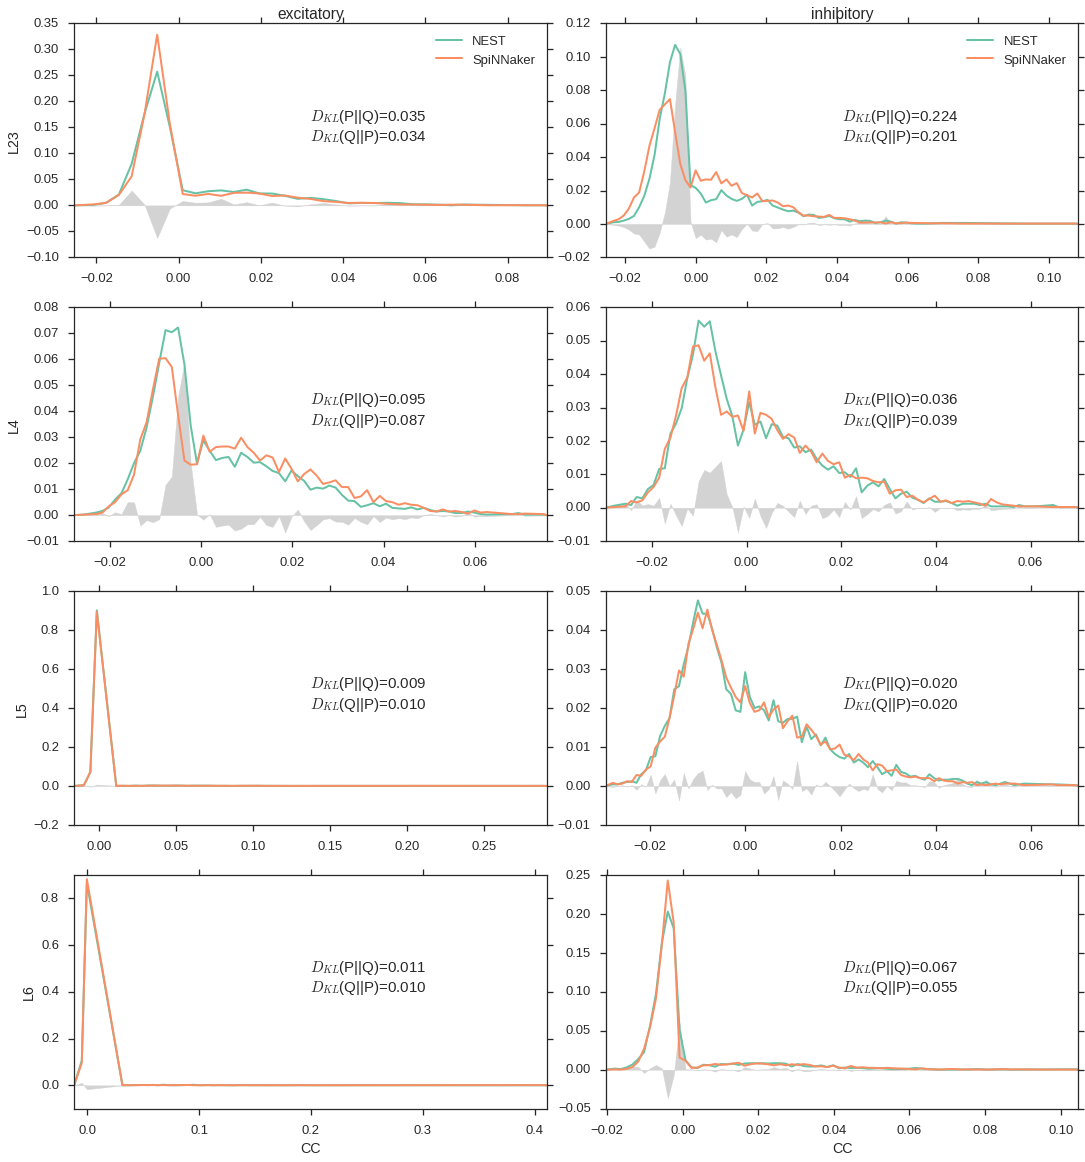

In [85]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    for typ_count in range(2):
        cc_nest = corrcoefs_nest[layer_count][typ_count]
        cc_spinnaker = corrcoefs_spinnaker[layer_count][typ_count]
        DKL, DKL_inv = dist.KL_test(cc_nest, cc_spinnaker, ax=ax[layer_count][typ_count], bins=100, 
                                    excl_zeros=True, mute=True, xlabel='CC')
        ax[layer_count][typ_count].set_xlabel('');
        ax[layer_count][typ_count].set_ylabel('' if typ_count else layer_name.split('_')[1])
        ax[layer_count][typ_count].text(.5, .5, r'$D_{KL}$(P||Q) = ' + '{:.3f}\n'.format(DKL) 
                                        + r'$D_{KL}$(Q||P) = ' + '{:.3f}'.format(DKL_inv), 
                                        fontsize=15, transform=ax[layer_count][typ_count].transAxes)
ax[0][0].legend(['NEST', 'SpiNNaker'])
ax[0][1].legend(['NEST', 'SpiNNaker'])
ax[0][0].set_title('excitatory')
ax[0][1].set_title('inhibitory')
ax[-1][0].set_xlabel('CC')
ax[-1][1].set_xlabel('CC');

##### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.06 	 p value = 0.00


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.12 	 p value = 0.00


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.11 	 p value = 0.00


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.05 	 p value = 0.00


Kolmogorov-Smirnov-Distance
	length 1 = 8836 	 length 2 = 10000
	D_KS = 0.08 	 p value = 0.00


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.02 	 p value = 0.18


Kolmogorov-Smirnov-Distance
	length 1 = 9604 	 length 2 = 10000
	D_KS = 0.13 	 p value = 0.00


Kolmogorov-Smirnov-Distance
	length 1 = 9801 	 length 2 = 10000
	D_KS = 0.04 	 p value = 0.00



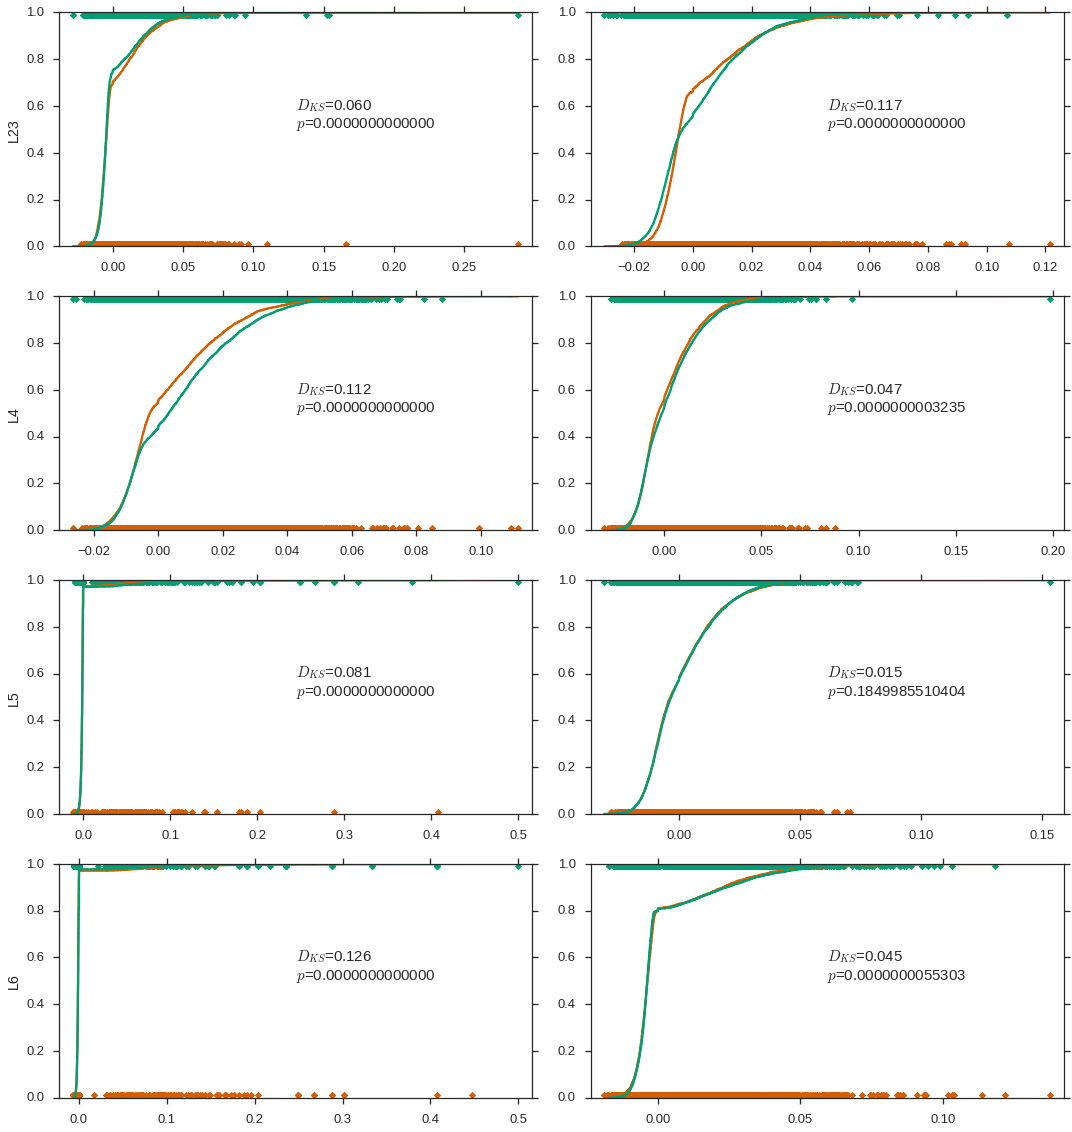

In [89]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    for typ_count in range(2):
        cc_nest = corrcoefs_nest[layer_count][typ_count]
        cc_spinnaker = corrcoefs_spinnaker[layer_count][typ_count]
        DKS, p = dist.KS_test(cc_nest, cc_spinnaker, ax=ax[layer_count][typ_count])
        ax[layer_count][typ_count].set_xlabel('');
        ax[layer_count][typ_count].set_ylabel('' if typ_count else layer_name.split('_')[1])
        ax[layer_count][typ_count].text(.5, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(DKS) 
                                        + r'$p$ = ' + '{:.13f}'.format(p), 
                                        fontsize=15, transform=ax[layer_count][typ_count].transAxes)

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.


Mann-Whitney-U-Test
	length 1 = 10000 	 length 2 = 10000
	U = 50133452.00   	 p value = 0.74


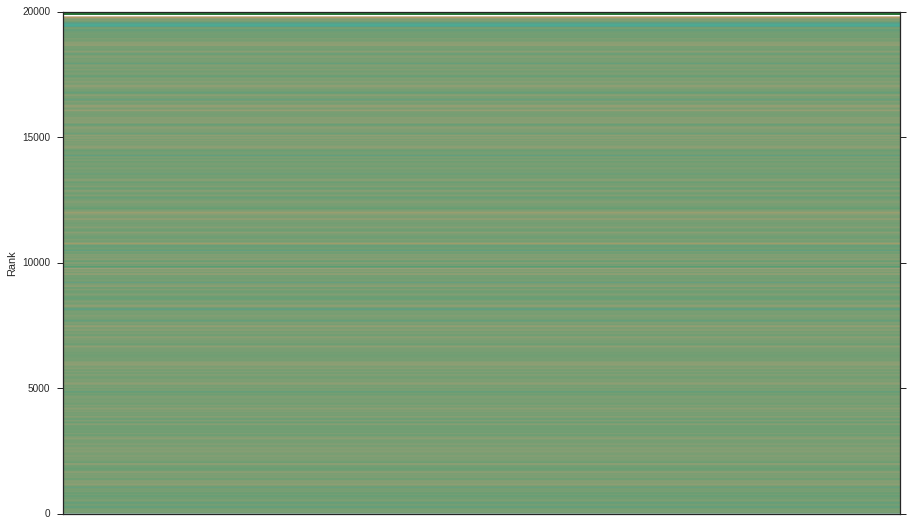

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
U, p = dist.MWU_test(dist_sample_1[:], dist_sample_2[:], ax=ax, excl_nan=True)

### Compare the correlation matrices

#### Heatmap

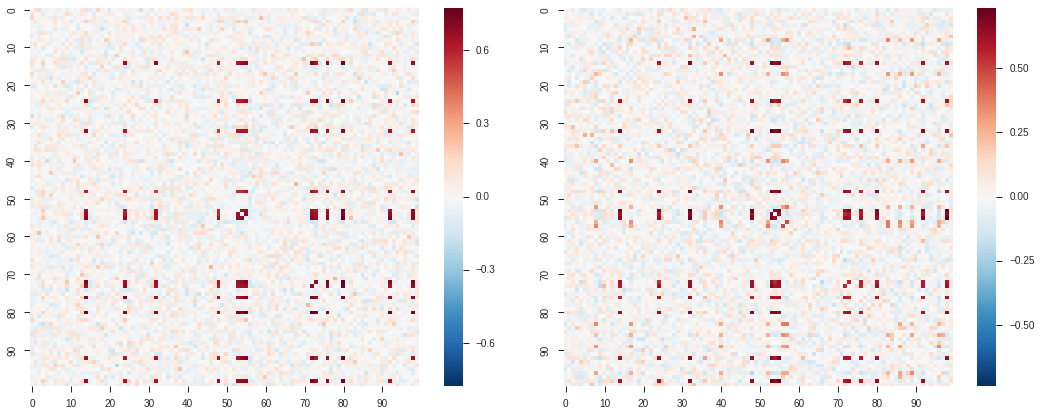

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

corr_matrix_1 = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_2 = matstat.corr_matrix(spiketrain_list_2)

matstat.plot_matrix(corr_matrix_1, ax[0], remove_autocorr=True)
matstat.plot_matrix(corr_matrix_2, ax[1], remove_autocorr=True)

#### Eigenvalue distribution

0.0

Eigenvalue distribution:
	EW_max = 9.49
	EW_min = 0.09

Redundancy = 0.11 


Eigenvalue distribution:
	EW_max = 9.21
	EW_min = 0.10

Redundancy = 0.11 



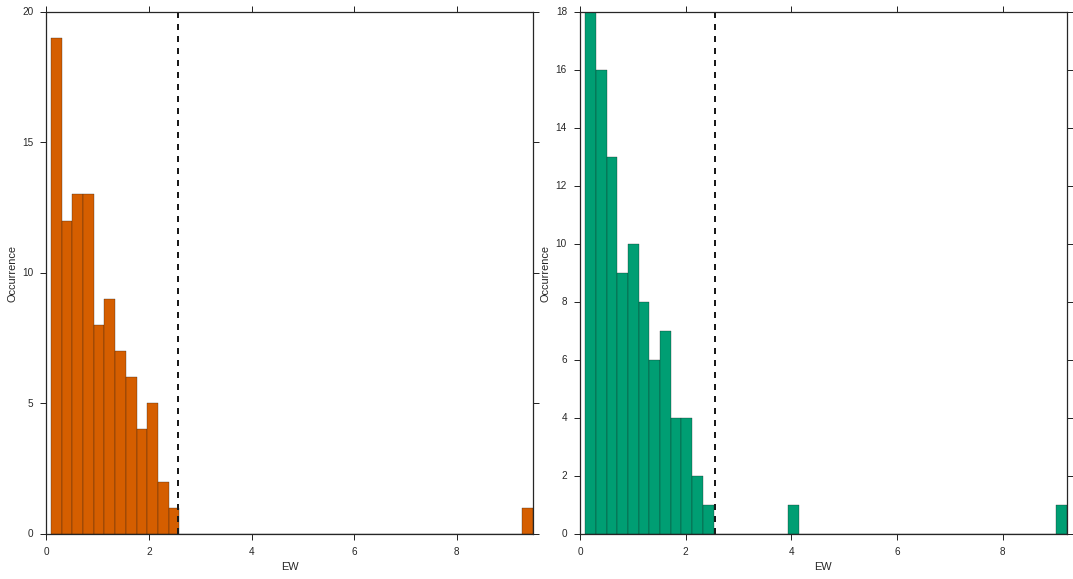

In [40]:
EWs_1, EVs_1 = eigh(corr_matrix_1)
EWs_2, EVs_2 = eigh(corr_matrix_2)

# Generate surrogates as reference
#def generate_ref(spiketrain_list):
#    surrogate_spiketrain_list = testdata.generate_surrogates(spiketrain_list, 
#                                                             dither_spikes, #_train, 
#                                                             dither=10*ms) #shift
#    surrogate_corr_matrix = matstat.corr_matrix(surrogate_spiketrain_list)
#    return eigh(surrogate_corr_matrix)[0]

EWmax_mean, EWmax_std = matstat.estimate_largest_eigenvalue(N=100,
                                                            trials=1,
                                                            t_stop=500,
                                                            rate=100,
                                                            bins=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()
__ = matstat.eigenvalue_distribution(EWs_1, ax[0], 
                                     #reference_EWs=generate_ref(spiketrain_list_1),
                                     reference_EW_max=EWmax_mean + 2*EWmax_std,
                                     bins=int(max(EWs_1))*5, color='r')
__ = matstat.redundancy(EWs_1)

__ = matstat.eigenvalue_distribution(EWs_2, ax[1], 
                                     #reference_EWs=generate_ref(spiketrain_list_2),
                                     reference_EW_max=EWmax_mean + 2*EWmax_std,
                                     bins=int(max(EWs_2))*5, color='g')
__ = matstat.redundancy(EWs_2)

#### Eigenvalue spectra

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

pc_nbr_1 = matstat.eigenvalue_spectra(EWs_1, method='SCREE', ax=ax[0], color='r')
pc_nbr_2 = matstat.eigenvalue_spectra(EWs_2, method='broken-stick', ax=ax[1], color='g')

#### Show eigenvectors

In [ ]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

#### Angles between eigenspaces

In [41]:
nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])


Angles between the eigenvectors
	13.38°

Angle between eigenspaces
	13.38°


#### Detect Assemblies

In [ ]:
print "\033[36mSample 1\033[0m\n"
__, corr_order_1 = matstat.detect_assemblies(EVs_1, EWs_1, detect_by='eigenvalue', EW_lim=3, sort=True, jupyter=True)

print "\033[36mSample 2\033[0m\n"
__, corr_order_2 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by='eigenvalues', EW_lim=3, sort=True, jupyter=True)

#### Show Assemblies in Correlation Matrix

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

ordered_matrix_1 = corr_matrix_1[corr_order_1, :][:, corr_order_1]
ordered_matrix_2 = corr_matrix_2[corr_order_2, :][:, corr_order_2]

matstat.plot_matrix(ordered_matrix_1, ax[0], labels=corr_order_1, remove_autocorr=True)
matstat.plot_matrix(ordered_matrix_2, ax[1], labels=corr_order_2, remove_autocorr=True)